In [1]:
import itertools
import pandas as pd
import os
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
match_rep_df = pd.read_csv("../checkpoints/match_rep_df.csv")

match_rep_df = match_rep_df[match_rep_df["sphering"] == True]

match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
6,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,NaN,1,20,6,...,0.000114,True,0.182630,57.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.279178,527841
8,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Widefield,9,NaN,1,20,6,...,0.000153,True,0.184205,67.777778,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.291127,1101611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4.0,1,20,5,...,0.000044,True,0.174914,57.777778,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",23.255814,0.244983,544244
354,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4.0,1,20,5,...,0.000044,True,0.157136,60.000000,"AGP, DNA, ER, Mito, RNA",NaN,"AGP, DNA, ER, Mito, RNA",20.930233,0.227059,543826
356,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,True,0.179268,58.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.253483,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,True,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567


In [52]:
def aggregate_duplicates(df, non_group_cols):
    """
    Group data on setting columns, calculate the mean for grouped rows
    (which are therefore duplicates).

    The returned dataframe will not contain Assay_Plate_Barcode, since 
    the unique barcodes cannot be reconciled into an aggregated mean, 
    so are therefore dropped.
    """
    # Columns to not be used for grouping
    # non_group_cols = [
    #     "Assay_Plate_Barcode",
    #     "Batch",
    #     "Vendor",
    #     "value_95_replicating",
    #     "Percent_Replicating",
    #     "Size_MB",
    #     "Size_MB_std",
    #     "Percent_Matching",
    #     "value_95_matching",
    #     "cell_count",
    #     "Sites-SubSampled",
    #     "BF_Zplanes", # Ignore since only one BF zplane is used
    #     "brightfield_z_plane_used",
    #     # Remove channel names due to some profiles having "AGP" features 
    #     # and others having "WGPhalloidin" instead
    #     "feature_channels_found",
    #     "channel_names"
    # ]
    # Find the columns that are not in non_group_cols
    diff = list(set(df.columns) - set(non_group_cols))
    # Group df by setting columns, find the mean, then reset the index
    df = df.groupby(diff, dropna=False, as_index=False).mean()
    return df

non_group_cols = [
    "Assay_Plate_Barcode",
    "Batch",
    "Vendor",
    "value_95_replicating",
    "Percent_Replicating",
    "Size_MB",
    "Size_MB_std",
    "Percent_Matching",
    "value_95_matching",
    "cell_count",
    "Sites-SubSampled",
    "BF_Zplanes", # Ignore since only one BF zplane is used
    "brightfield_z_plane_used",
    # Remove channel names due to some profiles having "AGP" features 
    # and others having "WGPhalloidin" instead
    "feature_channels_found",
    "channel_names",
    "vs-brightfield",
    "sphering"
]

group_cols = [col for col in match_rep_df.columns if col not in non_group_cols]

aggregate_duplicates(match_rep_df, non_group_cols)

merged_df = match_rep_df.groupby(group_cols) \
                    .agg({'Assay_Plate_Barcode': '_'.join}) \
                    .reset_index()
merged_df

,Plate_Map_Name,Modality,Images_per_well,Binning,Magnification,Number_of_channels,z_plane,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,sphering,Assay_Plate_Barcode
0,JUMP-MOA_compound_platemap,Confocal,4,1,10,6,12,0.4,dry,yes,2.0,4,True,BRO0117014_10x
1,JUMP-MOA_compound_platemap,Confocal,9,1,20,5,1,1.0,water,no,2.0,9,True,BRO0117033_20xb_BRO0117056_20x
2,JUMP-MOA_compound_platemap,Confocal,9,1,20,5,12,1.0,water,no,2.0,9,True,BRO0117056_20xb
3,JUMP-MOA_compound_platemap,Confocal,9,1,20,6,12,1.0,water,yes,1.0,9,True,BRO01177034_20x
4,JUMP-MOA_compound_platemap,Confocal,9,1,20,6,12,1.0,water,yes,4.0,9,True,BRO0117059_20X
5,JUMP-MOA_compound_platemap,Confocal,9,1,40,6,12,1.0,water,yes,4.0,9,True,BRO0117059_40x


# For the above aggregation, there needs to be a column that aggregates the setings. This string aggregation will be used when plotting the heatmap

In [63]:
# Compare all possible pairs of plates

profile_path = "../../jump-scope/profiles/"


def combination_compare(match_rep_df: pd.DataFrame, vendor: str, profile_path, no_difference_cols: list = ["Magnification", "Binning"]):
    """
    For a given vendor, find all possible pariwise plate comparisons and perform
    the KSTest between all features.

    Returns a dataframe with KSTest statistic and pvalues for each feature.
    Returned DataFrame also includes setting information for each plate (column
    appended with plate1 or plate2, accordingly.)

    no_difference_cols: if the plates to be compared differ in these values,
    they will be skipped. For example, 20x will not be compared with 10x
    """
    vendor_subset = match_rep_df[
        match_rep_df["Vendor"].str.contains(vendor, case=False) &
        ~match_rep_df["Batch"].str.contains("sitesub", case=False) # Exclude sitesub
    ]

    # Find plate combinations 
    plate_combinations = itertools.combinations_with_replacement(vendor_subset["Assay_Plate_Barcode"].to_list(), 2)

    # df to store results
    collated_df = pd.DataFrame()

    for i in plate_combinations:
        left_row = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[0]].reset_index()
        right_row = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[1]].reset_index()
        # Check that profiles posses the same values in the no_difference_cols columns
        if no_difference_cols is not None:
            if not left_row[no_difference_cols].equals(right_row[no_difference_cols]):
                print(f"""Skipping {left_row[no_difference_cols].values} vs {right_row[no_difference_cols].values} between {i}""")
                continue

        # Load profiles
        left_path = os.path.join(profile_path, left_row["Batch"].values[0], left_row["Assay_Plate_Barcode"].values[0], f"{left_row['Assay_Plate_Barcode'].values[0]}.csv.gz")
        left_profile = pd.read_csv(left_path)
        right_path = os.path.join(profile_path, right_row["Batch"].values[0], right_row["Assay_Plate_Barcode"].values[0], f"{right_row['Assay_Plate_Barcode'].values[0]}.csv.gz")
        right_profile = pd.read_csv(right_path)

        print(f"Comparing {left_row['Batch'].values[0]}/{i[0]} with {right_row['Batch'].values[0]}/{i[1]}")

        # Drop string columns
        left_profile_cols = left_profile.select_dtypes(include=['object'])
        left_profile = left_profile.drop(columns=left_profile_cols.columns)
        left_profile = left_profile.loc[:, ~left_profile.columns.str.contains("metadata", case=False)]

        right_profile_cols = right_profile.select_dtypes(include=['object'])
        right_profile = right_profile.drop(columns=right_profile_cols.columns)
        right_profile = right_profile.loc[:, ~right_profile.columns.str.contains("metadata", case=False)]

        # Gather settings for plate1 and plate2 to add to the same row with the corresponding statistic
        left = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[0]]
        left = left.add_suffix("_plate1").reset_index(drop=True)
        right = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[1]]
        right = right.add_suffix("_plate2").reset_index(drop=True)
        comparison_df = pd.concat([left, right], axis=1)

        for feature in left_profile.columns.intersection(right_profile.columns):
            kstest_comparison = scipy.stats.kstest(left_profile[feature].values, right_profile[feature].values)
            new_cols = pd.DataFrame.from_dict({
                f"{feature}_kstest_statistic": [kstest_comparison[0]],
                f"{feature}_kstest_pvalue": [kstest_comparison[1]]
            })
            # Append plate_comparison statistics as a column
            comparison_df = pd.concat([comparison_df, new_cols], axis=1)

        # Append two plate comparison as a new row
        collated_df = pd.concat([collated_df, comparison_df], axis=0)
    
    return collated_df

# collated_df = combination_compare(match_rep_df, "yokogawa_us", profile_path)


In [62]:
t1 = match_rep_df.iloc[[0]].reset_index()
t2 = match_rep_df.iloc[[1]].reset_index()

t1[["Magnification", "Binning"]].equals(t2[["Magnification", "Binning"]]), t1[["Magnification", "Binning"]], t2[["Magnification", "Binning"]]

(True,
    Magnification  Binning
 0             10        1,
    Magnification  Binning
 0             10        1)

In [33]:
for vend in match_rep_df["Vendor"].unique():
    print(vend)
    if os.path.isfile(f"{vend}_all_plate_comparison.csv"):
        continue
    comb_df = combination_compare(match_rep_df, vend, profile_path, no_difference_cols=None)
    comb_df.to_csv(f"{vend}_all_plate_comparison.csv", index=False)

MolDev
Nikon
PE
Yokogawa_Japan
Yokogawa_US


In [65]:
for vend in match_rep_df["Vendor"].unique():
    print(vend)
    if os.path.isfile(f"{vend}_all_plate_comparison_exclude_different_mag_binning_comparison.csv"):
        continue
    comb_df = combination_compare(match_rep_df, vend, profile_path, no_difference_cols=["Magnification", "Binning"])
    comb_df.to_csv(f"{vend}_all_plate_comparison_exclude_different_mag_binning_comparison.csv", index=False)

MolDev
Nikon
PE
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P2
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P3
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P4
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_3Plane/CP_Broad_Phenix_C_BIN1_P1
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_3Plane/CP_Broad_Phenix_C_BIN1_P2
Comparing Scope1_PE_Bin1_Confocal_1Plane/CP_Broad_Phenix_C_BIN1_1Plane_P1 with Scope1_PE_Bin1_Confocal_3Plane/CP_Broad_Phenix_C_BIN1_P3
Comp

In [68]:
t1 = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/notebooks/PE_all_plate_comparison_exclude_different_mag_binning_comparison.csv")
t2 = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/notebooks/PE_all_plate_comparison.csv")

t1.shape, t2.shape

((272, 8674), (528, 8674))

In [43]:
for i in range(10):
    if i == 4:
        continue
    print(i)

0
1
2
3
5
6
7
8
9


In [8]:
profile_path = "../../jump-scope/profiles/"
p1, p2 = "CP_Broad_Phenix_C_BIN1_1Plane_P1", "CPBroadPhenixC1PlaneP1"

p1_row = match_rep_df[
        (match_rep_df["Assay_Plate_Barcode"].str.contains(p1)) & 
        ~(match_rep_df["Batch"].str.contains("siteSub"))
        ]
p2_row = match_rep_df[
        (match_rep_df["Assay_Plate_Barcode"].str.contains(p2)) & 
        ~(match_rep_df["Batch"].str.contains("siteSub"))
        ]

p1_path = os.path.join(profile_path, p1_row["Batch"].values[0], p1, f"{p1}.csv.gz")
p1_profile = pd.read_csv(p1_path)

p2_path = os.path.join(profile_path, p2_row["Batch"].values[0], p2, f"{p2}.csv.gz")
p2_profile = pd.read_csv(p2_path)


In [31]:
len(p1_profile.columns), len(p2_profile.columns)

all(p1_profile.columns == p2_profile.columns)

idx = p2_profile.columns.get_loc("Cytoplasm_Texture_AngularSecondMoment_WGPhalloidin_3_02_256")
# idx = p1_profile.columns.get_loc("Cytoplasm_Texture_AngularSecondMoment_WGPhalloidin_3_02_256")

p1_profile.columns[idx], p2_profile.columns[idx]

p2_profile.drop(["hello", "there"], errors="ignore")

,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,...,Nuclei_Texture_Variance_WGPhalloidin_3_03_256,Nuclei_Texture_Variance_WGPhalloidin_5_00_256,Nuclei_Texture_Variance_WGPhalloidin_5_01_256,Nuclei_Texture_Variance_WGPhalloidin_5_02_256,Nuclei_Texture_Variance_WGPhalloidin_5_03_256,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_Cytoplasm,Metadata_Count_Nuclei,Metadata_Object_Count
0,CPBroadPhenixC1PlaneP1,A01,2621.4,4621.6,534.84,551.12,467.78,484.53,500.79,517.32,...,5.38680,5.42460,5.63470,5.45040,5.51910,3,1233,1233,1233,1233
1,CPBroadPhenixC1PlaneP1,A02,2669.8,4852.4,555.36,560.13,486.03,492.04,520.12,525.51,...,14.82200,14.81900,15.25500,14.80300,15.33900,3,1206,1206,1206,1206
2,CPBroadPhenixC1PlaneP1,A03,3573.7,6733.5,533.64,597.23,454.39,516.85,493.46,556.46,...,14.00700,14.14100,14.53500,14.21200,14.60800,3,751,751,751,751
3,CPBroadPhenixC1PlaneP1,A04,2677.1,4855.8,536.17,577.20,468.49,507.71,501.80,541.93,...,16.42400,16.64100,17.30600,16.56100,17.11700,3,1198,1198,1198,1198
4,CPBroadPhenixC1PlaneP1,A05,2885.8,5674.2,574.86,566.34,501.07,492.62,537.57,528.74,...,30.30300,30.11500,30.83500,30.14800,30.86600,3,810,810,810,810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,CPBroadPhenixC1PlaneP1,P20,2987.2,5445.8,593.43,576.29,520.03,504.02,556.26,539.57,...,13.19300,12.56900,13.14500,12.62800,13.37200,3,1069,1069,1069,1069
380,CPBroadPhenixC1PlaneP1,P21,3409.5,6174.2,579.65,621.27,503.16,544.41,541.17,582.44,...,7.90460,7.95890,8.26810,7.99560,8.29930,3,890,890,890,890
381,CPBroadPhenixC1PlaneP1,P22,2583.5,4628.1,589.82,593.38,522.26,527.51,555.54,560.01,...,1.03890,1.04420,1.06500,1.04320,1.07380,3,1234,1234,1234,1234
382,CPBroadPhenixC1PlaneP1,P23,2824.0,5222.2,608.75,596.70,537.91,526.29,573.03,561.17,...,0.79308,0.77029,0.77801,0.77302,0.77043,3,1097,1097,1097,1097


## Plot distributions for all feature types

1. For a single vendor, mean aggregate all of the different setting combinations
2. Plot the respective pvalues as a histogram for groups of features

In [ ]:
collated_df = pd.read_csv("collated_df.csv")



In [4]:
collated_df = collated_df.loc[:, ~collated_df.columns.str.contains('Unnamed')]
collated_df.to_csv("collated_df.csv", index=False)
collated_df = pd.read_csv("collated_df.csv")
collated_df

,Vendor_plate1,Batch_plate1,Plate_Map_Name_plate1,Assay_Plate_Barcode_plate1,Modality_plate1,Images_per_well_plate1,Sites-SubSampled_plate1,Binning_plate1,Magnification_plate1,Number_of_channels_plate1,...,Nuclei_Texture_Variance_Mito_20_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_20_03_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_00_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_00_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_01_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_01_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_02_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_02_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_03_256_kstest_pvalue
0,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00
1,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.156511,1.568093e-04,0.119326,8.031993e-03,0.121957,6.284149e-03,0.127298,3.778311e-03,0.124624,4.886141e-03
2,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.130319,3.338837e-03,0.154255,2.541835e-04,0.172872,2.529140e-05,0.164894,7.025869e-05,0.159574,1.351008e-04
3,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.054073,6.173195e-01,0.107137,2.415826e-02,0.128484,3.529538e-03,0.115684,1.167576e-02,0.125825,4.570690e-03
4,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.000000,1.188790e-227,0.824911,1.623218e-131,0.827626,1.541469e-132,0.825022,1.623213e-131,0.822584,1.681346e-130
5,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.997340,9.034807e-225,0.830175,1.439592e-133,0.830286,1.439590e-133,0.832945,1.321861e-134,0.827516,1.541475e-132
6,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.994736,2.554532e-222,0.819925,1.713493e-129,0.819814,1.713501e-129,0.819814,1.713501e-129,0.817099,1.718470e-128
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.251645,6.125455e-11,0.100397,3.956359e-02,0.094957,5.991857e-02,0.097738,4.846960e-02,0.102851,3.306485e-02
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.158759,1.382674e-04,0.081141,1.593403e-01,0.078481,1.868984e-01,0.081162,1.589909e-01,0.089127,9.557471e-02


In [169]:
cols = collated_df.columns[collated_df.columns.str.contains("pvalue")].to_list()
mean_p = collated_df[cols].mean(axis=1)
plot_df = pd.concat([collated_df[["Assay_Plate_Barcode_plate1", "Assay_Plate_Barcode_plate2"]], mean_p], axis=1)
plot_df

,Assay_Plate_Barcode_plate1,Assay_Plate_Barcode_plate2,0
0,BR00117060a10x,BR00117061a10x,0.046087
0,BR00117060a10x,BR00117062a10x,0.097018
0,BR00117060a10x,BR00117063b10x,0.095724
0,BR00117060a10x,BR00117061a,0.010383
0,BR00117060a10x,BR00117062a,0.010589
0,BR00117060a10x,BR00117063b,0.010753
0,BR00117061a10x,BR00117062a10x,0.079045
0,BR00117061a10x,BR00117063b10x,0.075559
0,BR00117061a10x,BR00117061a,0.010767
0,BR00117061a10x,BR00117062a,0.011298


In [91]:
def transversal_dataframe_update(dataframe: pd.DataFrame, combination: tuple, value: float):
    """
    For a given combination with size 2, update the dataframe (a matrix)
    that contains a column or row labelled with an element of combination
    """
    row = dataframe.index[dataframe.iloc[:,0] == combination[0]][0]
    col = dataframe.columns.get_loc(combination[1])
    dataframe.iloc[row, col] = value

    # Apply inverse
    inv_row = dataframe.index[dataframe.iloc[:,0] == combination[1]][0]
    inv_col = dataframe.columns.get_loc(combination[0])
    dataframe.iloc[inv_row, inv_col] = value

    return dataframe


def create_plot_matrix(dataframe: pd.DataFrame, comparison_col: str, plates_col: str = None):
    """For a 2-way plate comparison dataframe, 
    create a correlation style matrix"""

    matrix_dict = {}

    # Find the union of plate names, in case they appear in one column but not the
    # other as a result of itertools.combination
    if plates_col is None:
        plates = list(np.union1d(np.unique(dataframe["Assay_Plate_Barcode_plate1"]), (np.unique(dataframe["Assay_Plate_Barcode_plate2"]))))
    else:
        plates = dataframe[plates_col].to_list()

    # Set the first column in dict to the plate names
    matrix_dict[""] = plates

    # Now add individual plates as individual rows
    for pl in plates:
        matrix_dict.update({pl: []})

    # Fill dictionary with 0s, which will be replaced
    # Perfect correlation is 1
    {v.extend([np.nan] * len(plates)) for k, v in matrix_dict.items() if k != ""}

    matrix = pd.DataFrame.from_dict(matrix_dict)

    for compared_plates in zip(
        dataframe.loc[:, "Assay_Plate_Barcode_plate1"], 
        dataframe.loc[:, "Assay_Plate_Barcode_plate2"], 
        dataframe.loc[:, comparison_col]):
        matrix = transversal_dataframe_update(matrix, compared_plates[:2], compared_plates[2])

    return matrix


plot_matrix = create_plot_matrix(collated_df, "Nuclei_Texture_Variance_Mito_5_02_256_kstest_pvalue")

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_93427/2941095384.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataframe.columns, rotation=45, ha="right", rotation_mode="anchor")
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_93427/2941095384.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(dataframe.columns)


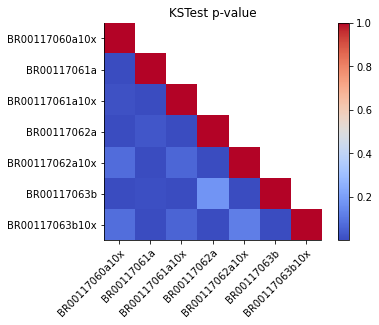

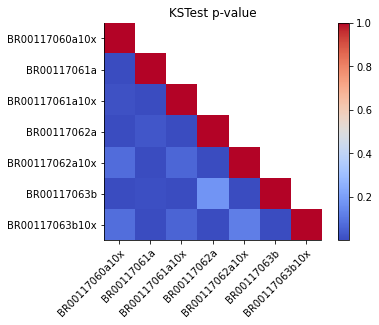

In [21]:
def plot_dataframe_matrix(dataframe: pd.DataFrame, title: str):
    fig, ax = plt.subplots()

    plot_matrix = dataframe.iloc[...,1:].values
    mask = np.triu(np.ones_like(plot_matrix), k=1).astype(bool)
    plot_matrix[mask] = np.nan

    matrix = ax.imshow(plot_matrix, cmap="coolwarm")
    fig.colorbar(matrix)
    ax.set_xticklabels(dataframe.columns, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(dataframe.columns)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    fig.set_facecolor("white")

    return fig

plot_dataframe_matrix(plot_matrix, "KSTest p-value")

In [12]:

test_df = collated_df.copy()

feature_cats = ["Texture", "RadialDistribution", "Intensity", "Granularity", "Nuclei", "Cells", "Cytoplasm"]

def aggregate_features(dataframe: pd.DataFrame, features: list, essential_match: str = None):
    """
    For a list of features, mean aggregate columns that contain.

    Essential match represents a string that must be matched by all columns
    """
    for feat in feature_cats:
        matches = [feat]
        if essential_match is not None:
            matches.append(essential_match)
        cols = dataframe.columns.values.tolist()
        cols = [col for col in cols if all(match in col for match in matches)]
        mean = dataframe[cols].mean(axis=1)
        dataframe[f"{'_'.join(matches)}"] = mean

    return dataframe

aggregated_df = aggregate_features(test_df, feature_cats, "pvalue")

aggregated_df

,Vendor_plate1,Batch_plate1,Plate_Map_Name_plate1,Assay_Plate_Barcode_plate1,Modality_plate1,Images_per_well_plate1,Sites-SubSampled_plate1,Binning_plate1,Magnification_plate1,Number_of_channels_plate1,...,Nuclei_Texture_Variance_Mito_5_02_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_03_256_kstest_pvalue,Texture_pvalue,RadialDistribution_pvalue,Intensity_pvalue,Granularity_pvalue,Nuclei_pvalue,Cells_pvalue,Cytoplasm_pvalue
0,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
1,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,3.778311e-03,0.124624,4.886141e-03,1.424736e-02,0.029616,0.108520,2.377201e-01,0.044400,0.050516,0.046460
2,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,7.025869e-05,0.159574,1.351008e-04,7.661098e-02,0.040198,0.126007,2.312030e-01,0.058651,0.124088,0.112752
3,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.167576e-02,0.125825,4.570690e-03,8.026173e-02,0.076328,0.118646,2.298764e-01,0.100996,0.094527,0.094262
4,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.623213e-131,0.822584,1.681346e-130,5.124165e-07,0.000149,0.095238,3.771966e-09,0.011836,0.011677,0.010765
5,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.321861e-134,0.827516,1.541475e-132,1.004440e-04,0.000163,0.095238,2.328886e-06,0.011979,0.011947,0.010968
6,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.713501e-129,0.817099,1.718470e-128,3.260684e-04,0.001278,0.095242,1.527640e-13,0.012595,0.011895,0.010894
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,4.846960e-02,0.102851,3.306485e-02,6.000659e-02,0.031962,0.151101,1.697912e-01,0.054014,0.105427,0.080320
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,1.589909e-01,0.089127,9.557471e-02,5.848245e-02,0.024070,0.124191,2.029676e-01,0.054263,0.091374,0.083710


In [ ]:
plot_feature_cats = [i+"_pvalue" for i in feature_cats]

# ft = plot_feature_cats[0]

for ft in plot_feature_cats:
    plot_matrix = create_plot_matrix(aggregated_df, ft)

    fig = plot_dataframe_matrix(plot_matrix, ft)

    fig.savefig(f"pvalue_{ft}.png", dpi=100, bbox_inches = "tight")


In [75]:
# View the top X number of sorted features
# ie. stting combinations that have low/high pvalues

feature_cats = ["Texture", "RadialDistribution", "Intensity", "Granularity", "Nuclei", "Cells", "Cytoplasm"]

aggregated_df = aggregate_features(test_df, feature_cats, "pvalue")

plot_feature_cats = [i+"_pvalue" for i in feature_cats]
setting_cols = [
    # 'Plate_Map_Name',
    # "Assay_Plate_Barcode",
    # 'z_plane',
    'aperture',
    # 'Binning',
    # 'Number_of_channels',
    # 'dry-immersion',
    # 'Modality',
    # 'Images_per_well',
    # 'simultaneous-excitation',
    'sites',
    'Magnification',
    ]

df_list = dict()

ft = plot_feature_cats[0]
p1_setting_cols = [col+"_plate1" for col in setting_cols]
p2_setting_cols = [col+"_plate2" for col in setting_cols]
dup_setting_cols = p1_setting_cols + p2_setting_cols
dup_setting_cols.append(ft)

print(ft)

# Remove pvalue = 1 rows
save_df = aggregated_df[~(aggregated_df[ft] == 1)]

save_df = save_df.sort_values(ft).reset_index()[dup_setting_cols]

save_df

# df_list = dict()

# for ft in plot_feature_cats:
#     p1_setting_cols = [col+"_plate1" for col in setting_cols]
#     p2_setting_cols = [col+"_plate2" for col in setting_cols]
#     dup_setting_cols = p1_setting_cols + p2_setting_cols
#     # dup_setting_cols.append(ft)

#     print(ft)

#     # Remove pvalue = 1 rows
#     save_df = aggregated_df[~(aggregated_df[ft] == 1)]

#     save_df = save_df.sort_values(ft).reset_index()[dup_setting_cols]

#     df_list[ft] = save_df

    # save_df.to_csv(f"sorted_{ft}.csv")


Texture_pvalue


,aperture_plate1,sites_plate1,Magnification_plate1,aperture_plate2,sites_plate2,Magnification_plate2,Texture_pvalue
0,0.45,1,10,0.75,9,20,5.124165e-07
1,0.45,1,10,0.75,9,20,5.360056e-06
2,0.45,1,10,0.75,9,20,9.684827e-06
3,0.45,1,10,0.75,9,20,2.833321e-05
4,0.45,1,10,0.75,9,20,3.119363e-05
5,0.45,1,10,0.75,9,20,5.594242e-05
6,0.45,1,10,0.75,9,20,8.686970e-05
7,0.45,1,10,0.75,9,20,1.004440e-04
8,0.45,1,10,0.75,9,20,1.317930e-04
9,0.45,1,10,0.75,9,20,1.428395e-04


In [74]:
# Do all of the settings influence the p-value equally? Ie. same settings
# outperform other settings routinely
df_list[list(df_list.keys())[0]] == df_list[list(df_list.keys())[6]]

,aperture_plate1,sites_plate1,Magnification_plate1,aperture_plate2,sites_plate2,Magnification_plate2
0,True,True,True,True,True,True
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True
4,True,True,True,True,True,True
5,True,True,True,True,True,True
6,True,True,True,True,True,True
7,True,True,True,True,True,True
8,True,True,True,True,True,True
9,True,True,True,True,True,True


1. Combine AssayPlateBarcode_plate1/2 into a single column
   1. This column will be "_".join aggregated
2. Group the dataframe by the setting columns
   1. These columns will be used to show that two profiles are derived from the same settings
3. Join aggregate assay_plate_barcode and then mean all other columns that are not groupby'd
4. Merge the duplicate setting columns
   1. ie. Magnification_Plate1/2 becomes Magnification

In [76]:
# Aggregate duplicate settings

# Combine Assay_Plate_Barcode_plate1/2
collated_df['Assay_Plate_Barcode'] = collated_df[['Assay_Plate_Barcode_plate1', 'Assay_Plate_Barcode_plate2']].agg('_'.join, axis=1)

setting_cols = [
    # 'Plate_Map_Name',
    'z_plane',
    'aperture',
    'Binning',
    'Number_of_channels',
    'dry-immersion',
    'Modality',
    'Images_per_well',
    'simultaneous-excitation',
    'sites',
    'Magnification',
    ]

def aggregate_similar_comparisons(collated_dataframe: pd.DataFrame, setting_column_names: list):

    p1_setting_cols = [col+"_plate1" for col in setting_column_names]
    p2_setting_cols = [col+"_plate2" for col in setting_column_names]
    dup_setting_cols = p1_setting_cols + p2_setting_cols

    eval_df = pd.DataFrame()
    for p1_set, p2_set in zip(p1_setting_cols, p2_setting_cols):
        if all(collated_dataframe[p1_set].isna()) and all(collated_dataframe[p2_set].isna()):
            # If a setting column is entirely NaN, exclude it since 
            # np.nan == np.nan = False
            continue
        comparison = collated_dataframe[p1_set] == collated_dataframe[p2_set]
        comparison.name = p1_set
        eval_df = pd.concat([eval_df, comparison], axis=1)

    # Between the two compared plates, determine those that have diverging settings
    # and can therefore not be merged
    collated_dataframe["merge_check"] = eval_df.all(axis=1)

    # Now we know which rows compare two plates that have the **same settings** and
    # can thus be aggregated with other rows that also compare the **same settings**
    # That is, we can aggregate the subset of rows where ["merge_check"] == True
    agg_subset = collated_dataframe[collated_dataframe["merge_check"] == True]
    non_agg_subset = collated_dataframe[collated_dataframe["merge_check"] == False]

    # feat_cols = [feat_col for feat_col in agg_subset.columns if feat_col not in dup_setting_cols]
    feat_cols = agg_subset.filter(regex='pvalue|kstest_statistic').columns

    # Let's create a dict to say that we wanna find the mean of each feature column
    merge_dict = {k: np.mean for k in feat_cols}

    # Aggregation of barcode strings
    merge_dict.update({"Assay_Plate_Barcode": "_".join})

    agg_subset = agg_subset.groupby(dup_setting_cols, dropna=False) \
                        .agg(merge_dict) \
                        .reset_index()

    # Concatenate the data and preserve the columns that survived aggregation for
    # the non-aggregated dataset
    merged_df = pd.concat([agg_subset, non_agg_subset[agg_subset.columns]], axis=0)

    return merged_df

aggregated_df = aggregate_similar_comparisons(collated_df, setting_cols)
aggregated_df

,z_plane_plate1,aperture_plate1,Binning_plate1,Number_of_channels_plate1,dry-immersion_plate1,Modality_plate1,Images_per_well_plate1,simultaneous-excitation_plate1,sites_plate1,Magnification_plate1,...,Nuclei_Texture_Variance_Mito_20_03_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_00_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_00_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_01_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_01_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_02_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_02_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_03_256_kstest_pvalue,Assay_Plate_Barcode
0,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,4.637381e-01,0.065086,4.328110e-01,0.069071,4.323251e-01,0.067544,4.319395e-01,0.069337,4.218271e-01,BR00117060a10x_BR00117060a10x_BR00117060a10x_B...
1,1,0.75,1,4,dry,Widefield,9,NaN,9,20,...,5.828415e-01,0.042101,6.096322e-01,0.042101,6.179544e-01,0.041233,6.216054e-01,0.043403,6.139527e-01,BR00117061a_BR00117061a_BR00117061a_BR00117062...
4,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,1.188790e-227,0.824911,1.623218e-131,0.827626,1.541469e-132,0.825022,1.623213e-131,0.822584,1.681346e-130,BR00117060a10x_BR00117061a
5,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,9.034807e-225,0.830175,1.439592e-133,0.830286,1.439590e-133,0.832945,1.321861e-134,0.827516,1.541475e-132,BR00117060a10x_BR00117062a
6,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,2.554532e-222,0.819925,1.713493e-129,0.819814,1.713501e-129,0.819814,1.713501e-129,0.817099,1.718470e-128,BR00117060a10x_BR00117063b
10,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,2.402874e-227,0.866979,1.559745e-148,0.861896,2.952285e-146,0.864437,2.168351e-147,0.858854,3.938284e-145,BR00117061a10x_BR00117061a
11,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,3.077657e-217,0.869833,1.098409e-149,0.867229,1.559734e-148,0.869771,1.098411e-149,0.861771,2.952293e-146,BR00117061a10x_BR00117062a
12,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,4.004950e-215,0.856812,5.147959e-144,0.856688,5.148793e-144,0.861958,2.952259e-146,0.854083,6.599654e-143,BR00117061a10x_BR00117063b
15,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,9.034807e-225,0.830064,1.439623e-133,0.830341,1.439589e-133,0.827682,1.541468e-132,0.822640,1.681324e-130,BR00117062a10x_BR00117061a
16,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,3.428709e-222,0.830175,1.439592e-133,0.835605,1.193084e-135,0.832945,1.321861e-134,0.827516,1.541475e-132,BR00117062a10x_BR00117062a


In [79]:
# View the top X number of sorted features
# ie. stting combinations that have low/high pvalues

feature_cats = ["Texture", "RadialDistribution", "Intensity", "Granularity", "Nuclei", "Cells", "Cytoplasm"]

aggregated_df_2 = aggregate_features(aggregated_df, feature_cats, "pvalue")

plot_feature_cats = [i+"_pvalue" for i in feature_cats]
setting_cols = [
    # 'Plate_Map_Name',
    # "Assay_Plate_Barcode",
    # 'z_plane',
    'aperture',
    # 'Binning',
    # 'Number_of_channels',
    # 'dry-immersion',
    # 'Modality',
    # 'Images_per_well',
    # 'simultaneous-excitation',
    'sites',
    'Magnification',
    ]

df_list = dict()

ft = plot_feature_cats[0]
p1_setting_cols = [col+"_plate1" for col in setting_cols]
p2_setting_cols = [col+"_plate2" for col in setting_cols]
dup_setting_cols = p1_setting_cols + p2_setting_cols
dup_setting_cols.append(ft)
dup_setting_cols.append("Assay_Plate_Barcode")

print(ft)

# Remove pvalue = 1 rows
save_df = aggregated_df_2[~(aggregated_df_2[ft] == 1)]

save_df = save_df.sort_values(ft).reset_index()[dup_setting_cols]

save_df

Texture_pvalue


,aperture_plate1,sites_plate1,Magnification_plate1,aperture_plate2,sites_plate2,Magnification_plate2,Texture_pvalue,Assay_Plate_Barcode
0,0.45,1,10,0.75,9,20,5.124165e-07,BR00117060a10x_BR00117061a
1,0.45,1,10,0.75,9,20,5.360056e-06,BR00117062a10x_BR00117061a
2,0.45,1,10,0.75,9,20,9.684827e-06,BR00117061a10x_BR00117061a
3,0.45,1,10,0.75,9,20,2.833321e-05,BR00117061a10x_BR00117063b
4,0.45,1,10,0.75,9,20,3.119363e-05,BR00117061a10x_BR00117062a
5,0.45,1,10,0.75,9,20,5.594242e-05,BR00117062a10x_BR00117062a
6,0.45,1,10,0.75,9,20,8.686970e-05,BR00117063b10x_BR00117061a
7,0.45,1,10,0.75,9,20,1.004440e-04,BR00117060a10x_BR00117062a
8,0.45,1,10,0.75,9,20,1.317930e-04,BR00117062a10x_BR00117063b
9,0.45,1,10,0.75,9,20,1.428395e-04,BR00117063b10x_BR00117062a


In [81]:
aggregated_df_2

,z_plane_plate1,aperture_plate1,Binning_plate1,Number_of_channels_plate1,dry-immersion_plate1,Modality_plate1,Images_per_well_plate1,simultaneous-excitation_plate1,sites_plate1,Magnification_plate1,...,Nuclei_Texture_Variance_Mito_5_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_03_256_kstest_pvalue,Assay_Plate_Barcode,Texture_pvalue,RadialDistribution_pvalue,Intensity_pvalue,Granularity_pvalue,Nuclei_pvalue,Cells_pvalue,Cytoplasm_pvalue
0,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.069337,4.218271e-01,BR00117060a10x_BR00117060a10x_BR00117060a10x_B...,4.409220e-01,0.432035,0.482954,5.334197e-01,0.441459,0.461148,0.457725
1,1,0.75,1,4,dry,Widefield,9,NaN,9,20,...,0.043403,6.139527e-01,BR00117061a_BR00117061a_BR00117061a_BR00117062...,5.351861e-01,0.515400,0.568642,5.328924e-01,0.536479,0.541485,0.540878
4,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.822584,1.681346e-130,BR00117060a10x_BR00117061a,5.124165e-07,0.000149,0.095238,3.771966e-09,0.011836,0.011677,0.010765
5,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.827516,1.541475e-132,BR00117060a10x_BR00117062a,1.004440e-04,0.000163,0.095238,2.328886e-06,0.011979,0.011947,0.010968
6,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.817099,1.718470e-128,BR00117060a10x_BR00117063b,3.260684e-04,0.001278,0.095242,1.527640e-13,0.012595,0.011895,0.010894
10,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.858854,3.938284e-145,BR00117061a10x_BR00117061a,9.684827e-06,0.005833,0.095238,2.089771e-05,0.011765,0.012670,0.010987
11,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.861771,2.952293e-146,BR00117061a10x_BR00117062a,3.119363e-05,0.005876,0.095238,9.648170e-04,0.012048,0.012966,0.012002
12,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.854083,6.599654e-143,BR00117061a10x_BR00117063b,2.833321e-05,0.009971,0.095239,2.015630e-04,0.012712,0.012388,0.012101
15,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.822640,1.681324e-130,BR00117062a10x_BR00117061a,5.360056e-06,0.000577,0.095238,2.265736e-06,0.011786,0.011747,0.010766
16,1,0.45,1,4,dry,Widefield,1,NaN,1,10,...,0.827516,1.541475e-132,BR00117062a10x_BR00117062a,5.594242e-05,0.004624,0.095243,9.321637e-04,0.012337,0.012872,0.011298


In [92]:
plot_feature_cats = [i+"_pvalue" for i in feature_cats]

for ft in plot_feature_cats:
    plot_matrix = create_plot_matrix(aggregated_df_2, ft, plates_col="Assay_Plate_Barcode")

    fig = plot_dataframe_matrix(plot_matrix, ft)

    fig.savefig(f"aggregated_pvalue_{ft}.png", dpi=100, bbox_inches = "tight")


KeyError: 'Assay_Plate_Barcode_plate1'

PE_all_plate_comparison.csv
Yokogawa_US_all_plate_comparison.csv
Nikon_all_plate_comparison.csv
Yokogawa_Japan_all_plate_comparison.csv
MolDev_all_plate_comparison.csv


In [5]:
df = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/notebooks/Nikon_all_plate_comparison.csv")
df

,Vendor_plate1,Batch_plate1,Plate_Map_Name_plate1,Assay_Plate_Barcode_plate1,Modality_plate1,Images_per_well_plate1,Sites-SubSampled_plate1,Binning_plate1,Magnification_plate1,Number_of_channels_plate1,...,Nuclei_Texture_Variance_Mito_20_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_20_03_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_00_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_00_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_01_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_01_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_02_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_02_256_kstest_pvalue,Nuclei_Texture_Variance_Mito_5_03_256_kstest_statistic,Nuclei_Texture_Variance_Mito_5_03_256_kstest_pvalue
0,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00
1,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.156511,1.568093e-04,0.119326,8.031993e-03,0.121957,6.284149e-03,0.127298,3.778311e-03,0.124624,4.886141e-03
2,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.130319,3.338837e-03,0.154255,2.541835e-04,0.172872,2.529140e-05,0.164894,7.025869e-05,0.159574,1.351008e-04
3,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.054073,6.173195e-01,0.107137,2.415826e-02,0.128484,3.529538e-03,0.115684,1.167576e-02,0.125825,4.570690e-03
4,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,1.000000,1.188790e-227,0.824911,1.623218e-131,0.827626,1.541469e-132,0.825022,1.623213e-131,0.822584,1.681346e-130
5,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.997340,9.034807e-225,0.830175,1.439592e-133,0.830286,1.439590e-133,0.832945,1.321861e-134,0.827516,1.541475e-132
6,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,NaN,1,10,4,...,0.994736,2.554532e-222,0.819925,1.713493e-129,0.819814,1.713501e-129,0.819814,1.713501e-129,0.817099,1.718470e-128
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.251645,6.125455e-11,0.100397,3.956359e-02,0.094957,5.991857e-02,0.097738,4.846960e-02,0.102851,3.306485e-02
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,NaN,1,10,4,...,0.158759,1.382674e-04,0.081141,1.593403e-01,0.078481,1.868984e-01,0.081162,1.589909e-01,0.089127,9.557471e-02


In [36]:
# Keep just the features

def aggregate_comparison_pvalues(df: pd.DataFrame, remove_cols: list):
    df = df.loc[:, (~df.columns.str.startswith(tuple(remove_cols))) & (df.columns.str.contains("_pvalue"))]
    # Drop Location, Number, Parent and Neighbour features
    df = df.loc[:, ~(df.columns.str.contains("|".join(["Location", "Number", "Parent", "Neighbors", "Children"])))]
    df = df.mean(axis=0).to_frame().T.melt(var_name="feature", value_name="pvalue")
    df["feature_type"] = df["feature"].str.split("_").str[1]
    return df

aggregate_comparison_pvalues(df, match_rep_df.columns)

,feature,pvalue,feature_type
0,Cells_AreaShape_Area_kstest_pvalue,0.291337,AreaShape
1,Cells_AreaShape_BoundingBoxArea_kstest_pvalue,0.298062,AreaShape
2,Cells_AreaShape_BoundingBoxMaximum_X_kstest_pv...,0.332637,AreaShape
3,Cells_AreaShape_BoundingBoxMaximum_Y_kstest_pv...,0.294857,AreaShape
4,Cells_AreaShape_BoundingBoxMinimum_X_kstest_pv...,0.302639,AreaShape
...,...,...,...
4186,Nuclei_Texture_Variance_RNA_20_03_256_kstest_p...,0.287928,Texture
4187,Nuclei_Texture_Variance_RNA_5_00_256_kstest_pv...,0.288407,Texture
4188,Nuclei_Texture_Variance_RNA_5_01_256_kstest_pv...,0.287928,Texture
4189,Nuclei_Texture_Variance_RNA_5_02_256_kstest_pv...,0.288407,Texture


In [53]:
pd.read_csv("Yokogawa_Japan_all_plate_comparison.csv")

,Vendor_plate1,Batch_plate1,Plate_Map_Name_plate1,Assay_Plate_Barcode_plate1,Modality_plate1,Images_per_well_plate1,Sites-SubSampled_plate1,Binning_plate1,Magnification_plate1,Number_of_channels_plate1,...,Nuclei_Texture_Variance_RNA_20_03_256_kstest_statistic,Nuclei_Texture_Variance_RNA_20_03_256_kstest_pvalue,Nuclei_Texture_Variance_RNA_5_00_256_kstest_statistic,Nuclei_Texture_Variance_RNA_5_00_256_kstest_pvalue,Nuclei_Texture_Variance_RNA_5_01_256_kstest_statistic,Nuclei_Texture_Variance_RNA_5_01_256_kstest_pvalue,Nuclei_Texture_Variance_RNA_5_02_256_kstest_statistic,Nuclei_Texture_Variance_RNA_5_02_256_kstest_pvalue,Nuclei_Texture_Variance_RNA_5_03_256_kstest_statistic,Nuclei_Texture_Variance_RNA_5_03_256_kstest_pvalue
0,Yokogawa_Japan,Scope1_Yokogawa_Japan_20X,JUMP-MOA_compound_platemap,20201021T092317,Confocal,9,NaN,1,20,5,...,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00
1,Yokogawa_Japan,Scope1_Yokogawa_Japan_20X,JUMP-MOA_compound_platemap,20201021T092317,Confocal,9,NaN,1,20,5,...,0.065104,0.390235,0.270833,8.527383e-13,0.276042,2.780181e-13,0.268229,1.480912e-12,0.270833,8.527383e-13
2,Yokogawa_Japan,Scope1_Yokogawa_Japan_40X,JUMP-MOA_compound_platemap,20201020T134356,Confocal,2,NaN,1,40,5,...,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00


PE_all_plate_comparison.csv
Yokogawa_US_all_plate_comparison.csv
Nikon_all_plate_comparison.csv
Yokogawa_Japan_all_plate_comparison.csv
MolDev_all_plate_comparison.csv


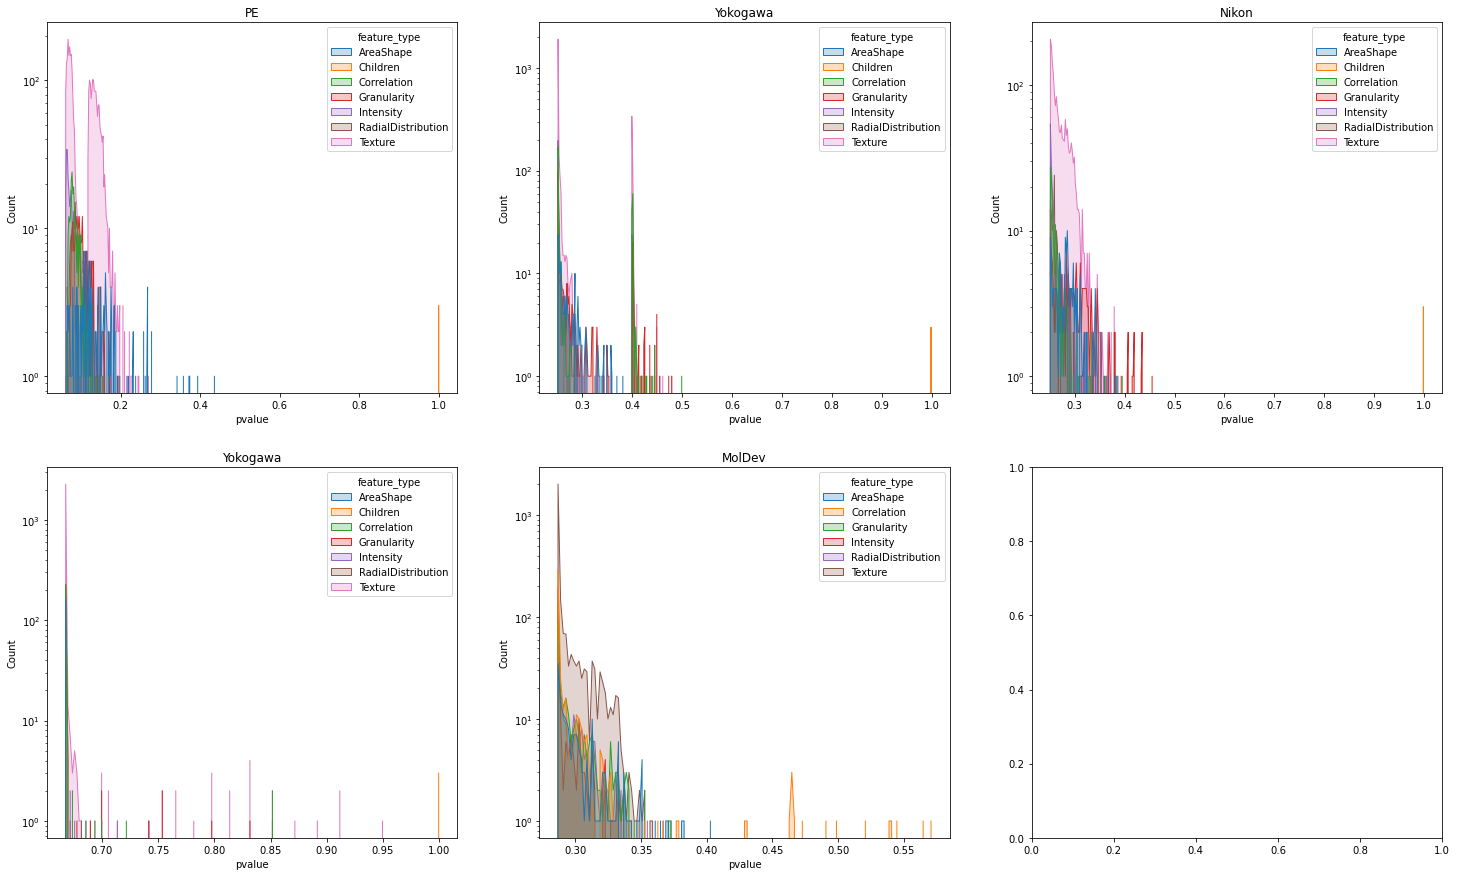

In [71]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))

comparison_paths = [i for i in os.listdir(".") if i.endswith("all_plate_comparison.csv")]

for k, pth in enumerate(comparison_paths):
    print(pth)
    i = k % 3
    j = k // 3
    df = pd.read_csv(pth)
    df = aggregate_comparison_pvalues(df, match_rep_df.columns)
    # sns.histplot(df, x="pvalue", hue="feature_type", element="poly", ax=ax[j, i], log_scale=(False, True), binwidth=0.002)
    sns.histplot(df, x="pvalue", hue="feature_type", element="poly", ax=ax[j, i], log_scale=(False, True), binwidth=0.002)
    ax[j, i].set_title(f"{pth.split('_')[0]}")


MolDev_all_plate_comparison_exclude_different_mag_binning_comparison.csv
Nikon_all_plate_comparison_exclude_different_mag_binning_comparison.csv
Yokogawa_US_all_plate_comparison_exclude_different_mag_binning_comparison.csv
PE_all_plate_comparison_exclude_different_mag_binning_comparison.csv
Yokogawa_Japan_all_plate_comparison_exclude_different_mag_binning_comparison.csv


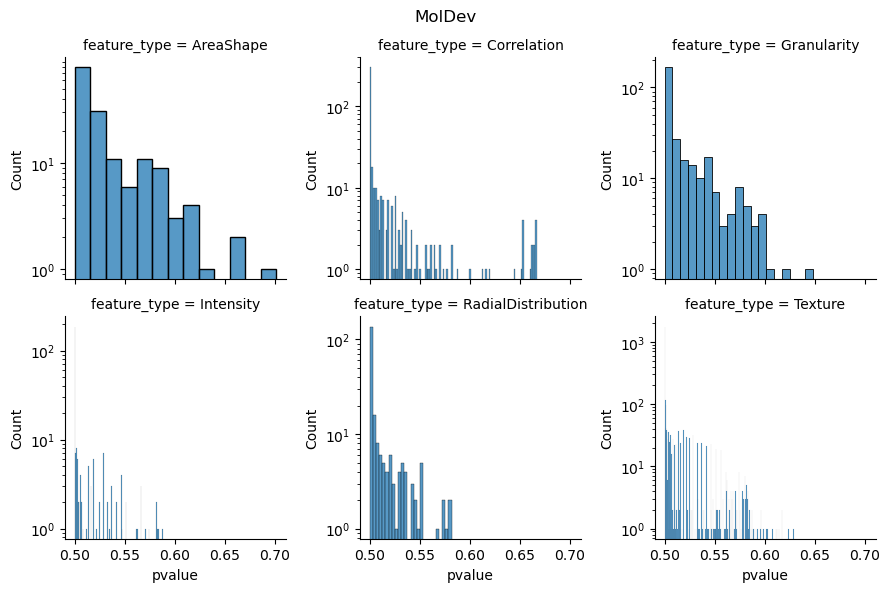

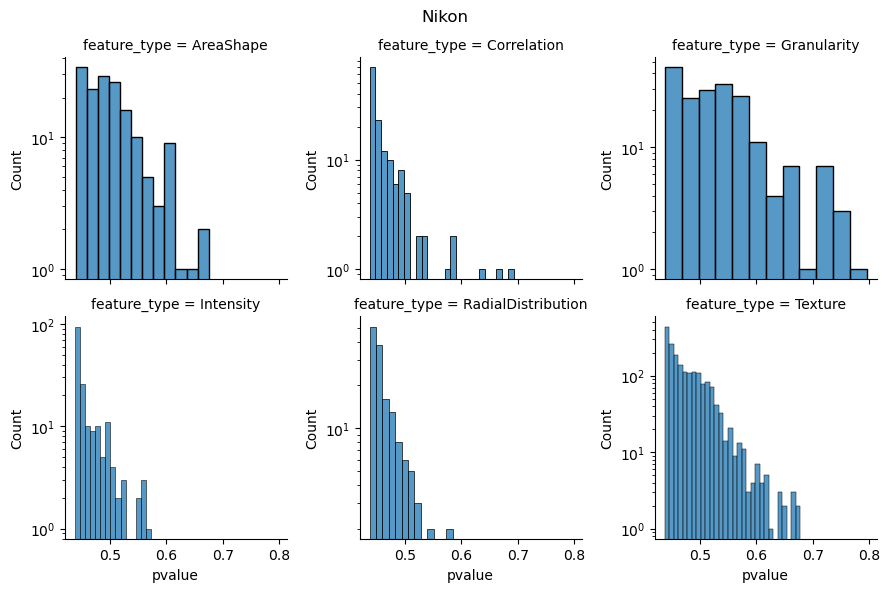

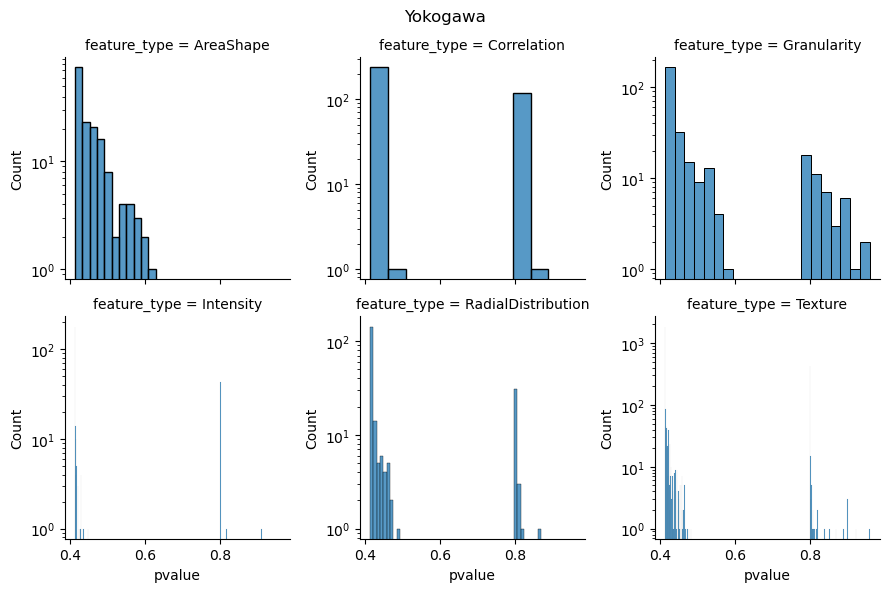

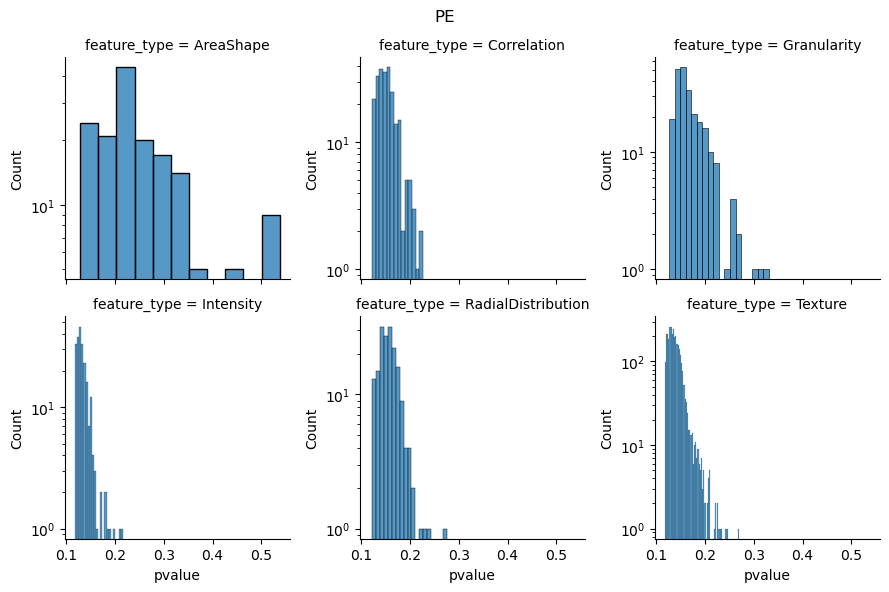

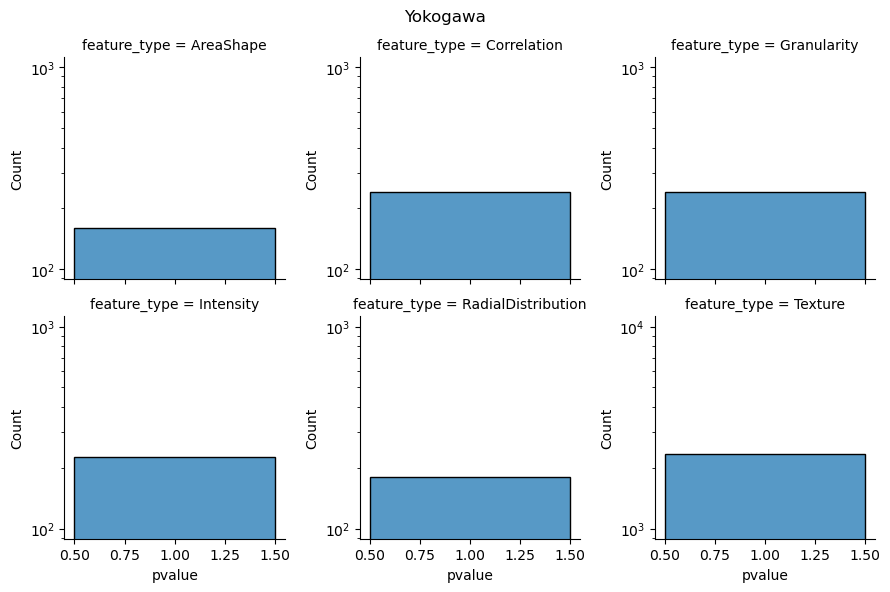

In [76]:
comparison_paths = [i for i in os.listdir(".") if i.endswith("all_plate_comparison_exclude_different_mag_binning_comparison.csv")]

for k, pth in enumerate(comparison_paths):
    print(pth)
    i = k % 3
    j = k // 3
    df = pd.read_csv(pth)
    agg_df = aggregate_comparison_pvalues(df, match_rep_df.columns)

    # Select columns with 'float64' dtype  
    float64_cols = list(agg_df.select_dtypes(include='float64'))
    # The same code again calling the columns
    agg_df[float64_cols] = agg_df[float64_cols].astype('float32')
    g = sns.FacetGrid(agg_df, col="feature_type", col_wrap=3, sharey=False)
    g.map_dataframe(sns.histplot, x="pvalue", log_scale=[False, True])
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{pth.split('_')[0]}")


In [74]:
t = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/notebooks/Yokogawa_Japan_all_plate_comparison_exclude_different_mag_binning_comparison.csv")

t[["Batch_plate1", "Assay_Plate_Barcode_plate2"]]

,Batch_plate1,Assay_Plate_Barcode_plate2
0,Scope1_Yokogawa_Japan_20X,20201021T092317
1,Scope1_Yokogawa_Japan_40X,20201020T134356


<AxesSubplot:xlabel='pvalue', ylabel='Count'>

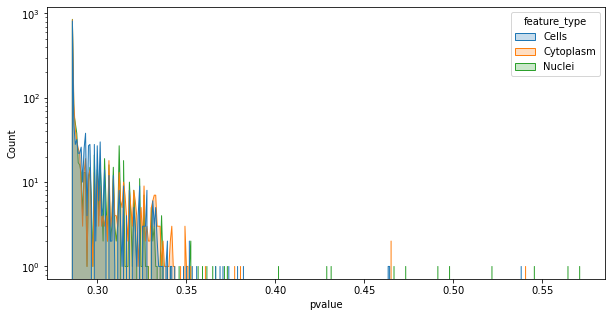

In [32]:

df = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/notebooks/MolDev_all_plate_comparison.csv")

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(aggregate_comparison_pvalues(df, match_rep_df.columns), x="pvalue", hue="feature_type", element="poly", ax=ax, log_scale=(False, True))